# <span style = "color: red" > Unsupervised Algorithms - Week 5 Final Project: Fashion-MNIST

**By Manuela Scheibe**

For this project I have selected the Fashion-MNIST dataset.

Fashion-MNIST is a dataset of Zalando product images containing 60,000 training samples and 10,000 test samples. Each sample is a 28x28 grayscale image paired with a label from one of 10 categories.

It can be directly downloaded and accessed through Python.
https://www.tensorflow.org/datasets/catalog/fashion_mnist

The real MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits in the same standard format. The Fashion-MNIST presents a significantly higher difficulty level than MNIST due to its greater intra-class variability and visual complexity, making it a more realistic benchmark for evaluating image classification models.

While the Fashion-MNIST dataset provides labels across 10 categories, its compact and standardized format makes it especially valuable for unsupervised learning tasks such as clustering and dimensionality reduction where the goal is to uncover latent structure in the image space without relying on the class annotations.

**The objective is to cluster the fashion items into 10 groups that ideally align with the predefined categories. The performance of this unsupervised approach will then be evaluated in comparison to a supervised learning method.**

https://en.wikipedia.org/wiki/Fashion_MNIST

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import NMF

import os

from google.colab import drive
drive.mount('/content/drive')

working_dir = '/content/drive/MyDrive/Fashion_MNIST'

if not os.path.exists(working_dir):
  os.makedirs(working_dir)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Print the shape of the training and testing data
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test: ' + str(X_test.shape))
print('Y_test: ' + str(y_test.shape))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


## <span style = "color: red" > Data Description
The dataset consists of:
- 60,000 labeled grayscale images for training
- 10,000 labeled grayscale images for testing

Both training and test sets are stored as NumPy arrays with the shape (n_samples, height, width) where each image is 28x28 pixels in grayscale. Pixel intensities are represented as integers in the range 0-255.

The associated category labels are digits 0-9, each corresponding to a specific type of fashion item.

The Fashion-MNIST items are: `T-shirt/top`,  `Trouser`, `Pullover`, `Dress`, `Coat`, `Sandal`, `Shirt`, `Sneaker`, `Bag` and `Ankle boot`.

(https://eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/further-steps-in-machine-learning/machine-learning-use-case-in-fashion/examination-review-machine-learning-use-case-in-fashion/what-is-the-difference-between-the-fashion-mnist-dataset-and-the-classic-mnist-dataset/#:~:text=Each%20image%20in%20the%20Fashion-MNIST%20dataset%20is%20labeled,Coat%2C%20Sandal%2C%20Shirt%2C%20Sneaker%2C%20Bag%2C%20and%20Ankle%20boot.)


The training and test datasets are class-balanced.

There are no missing values in the datasets.

In [ ]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(np.uint8(0), np.uint8(255), np.uint8(0), np.uint8(255))

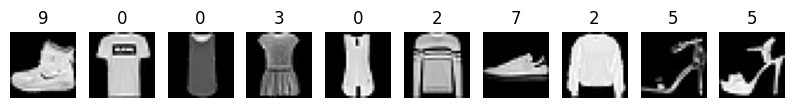

In [ ]:
plt.figure(figsize=(10,10))
unique_classes = np.unique(y_train)
unique_classes_no = len(unique_classes)
for no in range(unique_classes_no):
  plt.subplot(1,unique_classes_no,no+1)
  plt.imshow(X_train[no], cmap='gray')
  plt.axis('off')
  plt.title(y_train[no])


In [ ]:
# Get the unique values and their counts
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)


# Display the unique classes and their counts
for class_label, count in zip(unique_classes_train, counts_train):
    print(f"Class in training data {class_label}: {count}")
print("\n")
for class_label, count in zip(unique_classes_test, counts_test):
    print(f"Class in testing data {class_label}: {count}")

Class in training data 0: 6000
Class in training data 1: 6000
Class in training data 2: 6000
Class in training data 3: 6000
Class in training data 4: 6000
Class in training data 5: 6000
Class in training data 6: 6000
Class in training data 7: 6000
Class in training data 8: 6000
Class in training data 9: 6000


Class in testing data 0: 1000
Class in testing data 1: 1000
Class in testing data 2: 1000
Class in testing data 3: 1000
Class in testing data 4: 1000
Class in testing data 5: 1000
Class in testing data 6: 1000
Class in testing data 7: 1000
Class in testing data 8: 1000
Class in testing data 9: 1000


In [ ]:
np.isnan(X_train).any(), np.isnan(X_test).any()

(np.False_, np.False_)

## <span style = "color: red" > Exploratory Data Analysis and Data Cleaning

The exploratory data analysis aims to gain an initial understanding of the dataset, identify structural patterns and highlight potential relationships between classes. This provides insights that guide subsequent modeling and evaluation steps, particularly in unsupervised learning contexts.

The following aspects are examined:

- Visualization of 10 sample images per class to illustrate intra-class and inter-class variability

- Computation and display of the average image for each class to capture prototypical patterns

- Calculation of correlation coefficients between the average class images to assess inter-class similarity

- Examination of grayscale pixel intensity distribution range to evaluate the necessity of normalization

- Histograms of grayscale pixel intensity mean to analyze pixel-level characteristics between classes and detect outliers.

Both datasets are analyzed as unique dataset.

In [ ]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

pix_dim = X.shape[1]

### <span style = "color: red" > Sample Images

10 representative images per class are visualized to evaluate intra-class consistency and inter-class variability.

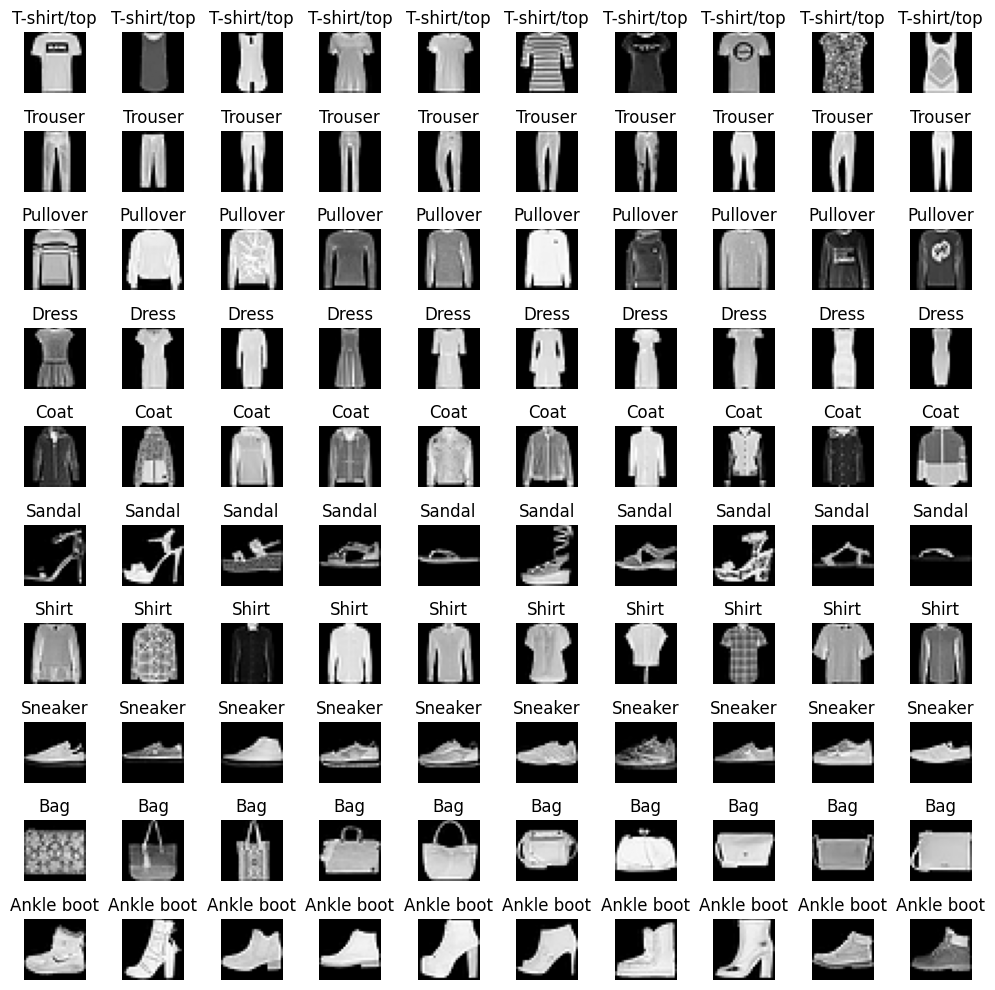

In [ ]:
class_labels_real = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


plt.figure(figsize=(10,10))
n_examples = 10
unique_classes = np.unique(y)
unique_classes_no = len(unique_classes)

for class_label in range(unique_classes_no):
    # take first `n_examples` indices for this class
    class_indices = np.where(y == class_label)[0][:n_examples]
    class_images = X[class_indices]

    for no in range(n_examples):
        plt.subplot(unique_classes_no, n_examples, class_label * n_examples + no + 1)
        plt.imshow(class_images[no], cmap='gray')
        plt.axis('off')
        plt.title(class_labels_real[class_label])

plt.tight_layout()
plt.show()


**Within-Class Variability (Intra-class)**
- Consistency of shape: Images within the same class (`Pullover`, `Coat`, `Shirt` and `Sneaker`) generally share a common silhouette, making them easily recognizable as belonging to the same category.

- Variation in style: Despite this consistency, some classes exhibit greater diversity in form and appearance. For example, `Sandal`, `Bag`, and `Ankle boot` show more pronounced differences in shape and design across samples, reflecting higher intra-class variability.

**Between-Class Variability (Inter-class)**
- Clear silhouette differences: Some classes such as `Trouser` vs. `Bag` or `Sneaker` vs. `Dress` are visually very distinct, making them easier for models to separate.

- High similarity between certain classes: Other categories like `Pullover`, `Coat` and `Shirt` share overlapping shapes and textures, which reduces inter-class variability and makes classification harder.


### <span style = "color: red" > Average Images to Assess Class Prototype

For each class, a prototype image is obtained by computing the mean pixel intensity across all images resulting in an averaged overlay representation.

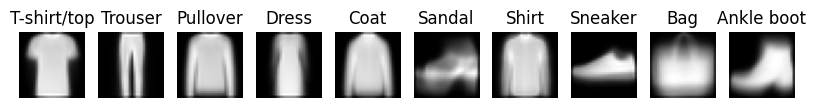

In [ ]:
X_flat = X.reshape(-1, pix_dim*pix_dim)
df = pd.DataFrame(X_flat)
df.index = y
averaged_pix_df = df.groupby(df.index).mean()
averaged_pix = averaged_pix_df.values.astype(int).reshape(-1,pix_dim,pix_dim)

plt.figure(figsize=(10,10))
for category in range(unique_classes_no):
  plt.subplot(1,unique_classes_no, category + 1)
  plt.imshow(averaged_pix[category], cmap='gray')
  plt.axis('off')
  plt.title(class_labels_real[category])

The classes `Pullover`, `Coat` and `Shirt` exhibit nearly identical silhouettes, whereas `Sandal` and `Bag` yield diffuse prototype images indicative of high intra-class variability.

### <span style = "color: red" > Similarity Matrix by Pearson Correlation Coefficients

Pearson correlation coefficients between the class prototypes were computed to quantify pairwise similarity. The resulting similarity matrix then served as the basis for hierarchical clustering performed with Euclidean distance and average linkage.

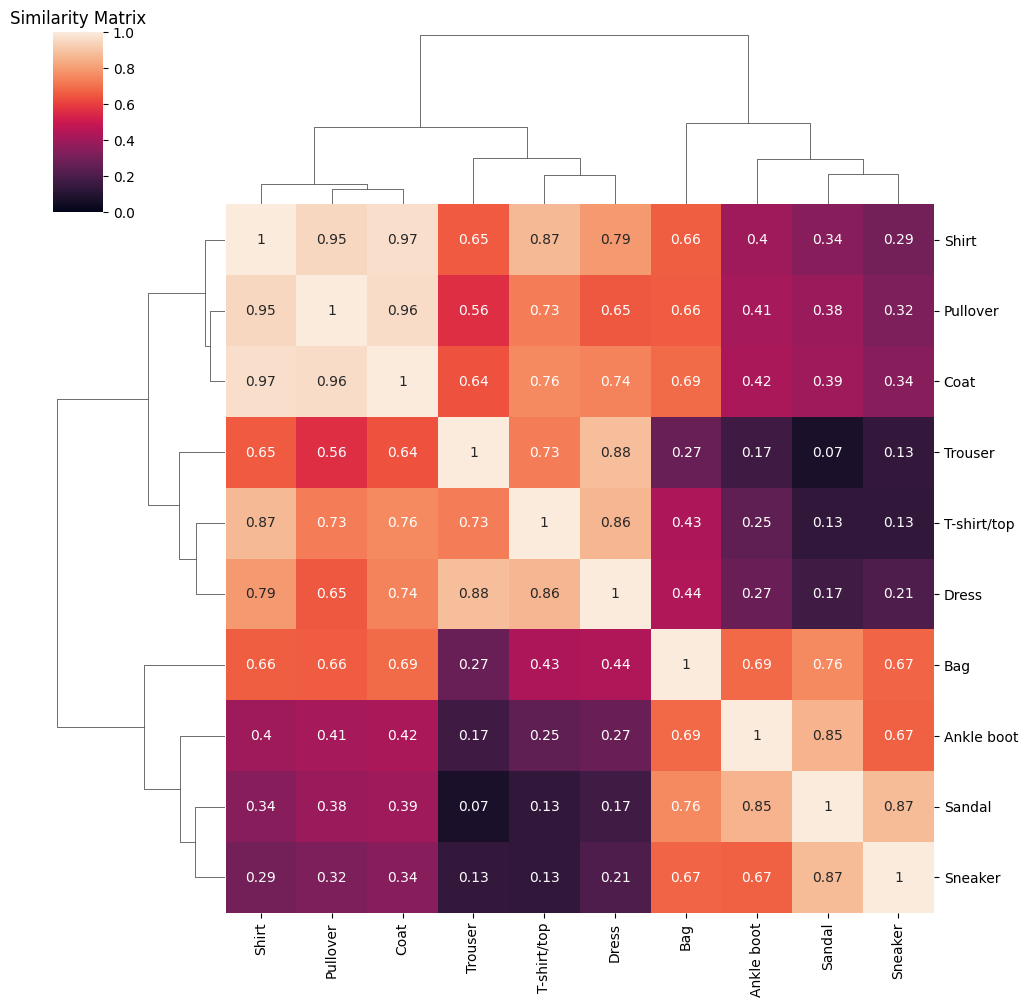

In [ ]:
similarity_matrix = np.corrcoef(averaged_pix_df)
similarity_matrix = pd.DataFrame(similarity_matrix, index=class_labels_real, columns=class_labels_real)

sns.clustermap(similarity_matrix, annot=True, vmin = 0, vmax = 1)
plt.title('Similarity Matrix')
plt.show()




Using the dendrogram, 4 clusters can be identified:

- `Shirt`, `Pullover` and `Coat`  
- `Trouser`, `T-shirt/top` and `Dress`  
- `Bag`
- `Ankle boot`, `Sandal` and `Sneaker`

### <span style = "color: red" > Evaluation for  Necessity of Normalization / Transformation

The range of pixel values in each image was examined to determine whether normalization of the intensity scale was necessary.

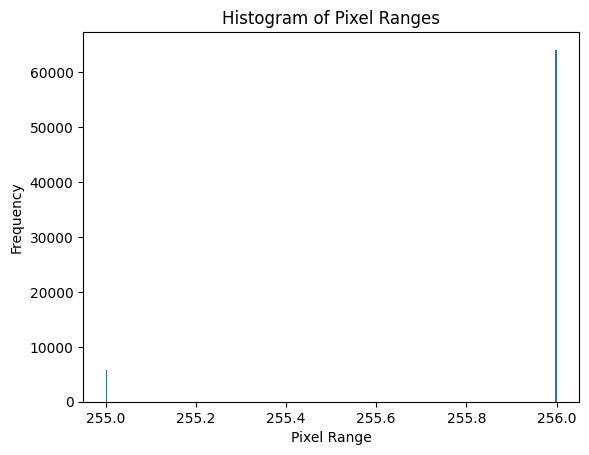

In [ ]:
min_pixel_per_image = np.min(X_flat, axis = 1)
max_pixel_per_image = np.max(X_flat, axis = 1)
range_pixel_per_image = (max_pixel_per_image - min_pixel_per_image) + np.ones(len(min_pixel_per_image))

plt.hist(range_pixel_per_image, bins=256)
plt.xlabel('Pixel Range')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Ranges')
plt.show()

The images appear to be already normalized, as the pixel value ranges per image nearly span the full 0-255 scale.

Since each pixel in an image shares the same scale, grayscale in this case, *no* transformation of the feature value range is required for subsequent modeling.

### <span style = "color: red" > Grayscale Pixel Intensity Mean per Class

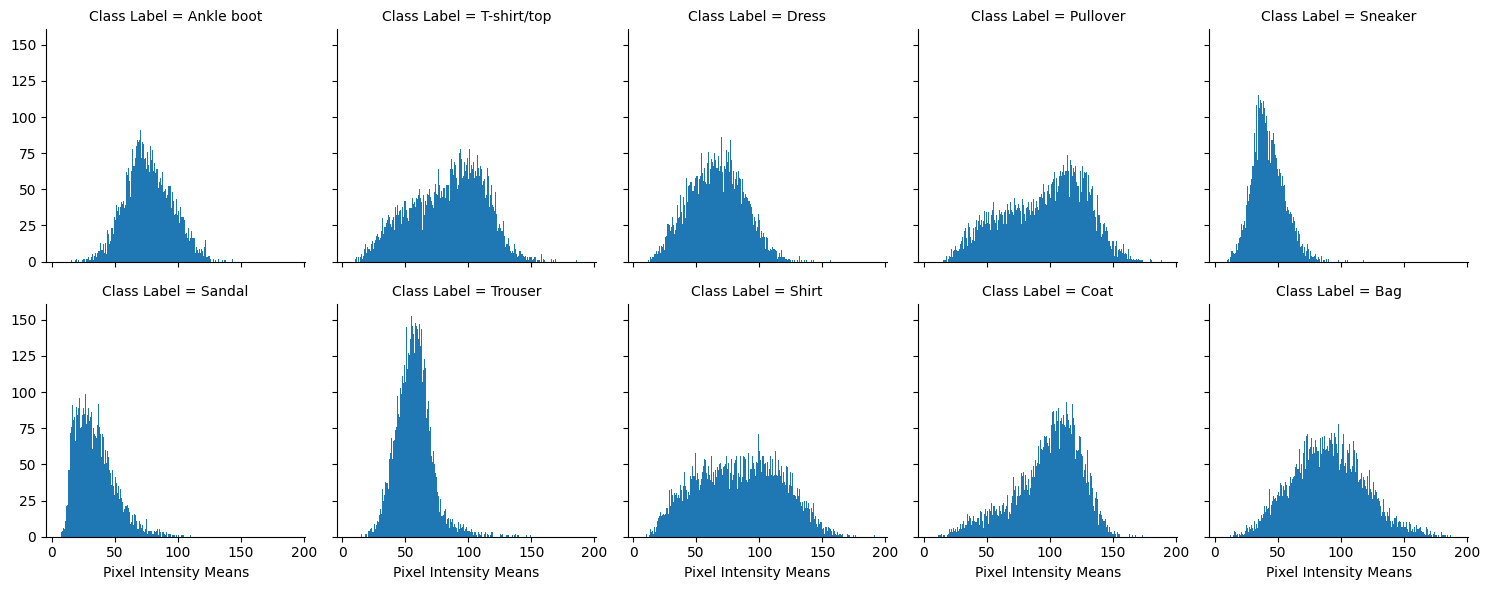

In [ ]:
# Create a DataFrame suitable for seaborn.catplot
means_df = pd.DataFrame({'Pixel Intensity Means': df.mean(axis=1)})
means_df['Class Label'] = means_df.index.map(lambda x: class_labels_real[x])


# Use FacetGrid to create histograms for each class
g = sns.FacetGrid(means_df, col='Class Label', col_wrap=5)
g.map(plt.hist, 'Pixel Intensity Means', bins=256)

plt.show()

Images of `Sneaker`, `Sandal` and `Trouser` are typically darker as the items cover less of the frame, whereas the remaining categories show more variation in mean grayscale values.
*No* anomalous mean grayscale values were observed suggesting the absence of outliers.

### <span style = "color: red" > Data Cleaning

*No* data cleaning is required for the Fashion-MNIST dataset due to the following reasons:

- Uniform Image Format: All samples are 28x28 grayscale images with consistent structure and dimensions eliminating the need for resizing or format standardization.

- Class Balance: Each of the 10 categories is evenly represented in both training and test sets (6,000 and 1,000 samples per class, respectively) so no rebalancing is necessary.-

- No Missing Values: Both training and test sets are complete with no missing entries or NaNs detected in the pixel arrays.

- Normalized Pixel Range: Pixel intensities span the full 0-255 range across images indicating that the data is already scaled appropriately for modeling.

- No Outlier Indicators: Mean grayscale values per class show no anomalies, suggesting the absence of outliers that would require removal or correction.

- No Duplicates: The dataset contains only unique images confirmed by duplicate checks on the flattened pixel matrix.





In [ ]:
df.shape, df.drop_duplicates().shape

((70000, 784), (70000, 784))

## <span style = "color: red" > Unsupervised Learning: Model Optimization and Hyperparameter Tuning

For efficiency model optimization is carried out on a smaller portion of the Fashion-MNIST dataset. The subset includes 15,000 labeled grayscale images taken from the beginning of the training set. Despite the reduction the subset remains class-balanced with items arranged in random order.

The optimized model is going to be tested on the full test dataset.

For clustering always full dataset, both training and test, is utilized as the task is unsupervised and does not require the target variable for training. However, this approach necessitates retraining whenever a new test dataset is introduced.

In [ ]:
train_no = 15000
# Get the unique values and their counts
unique_classes_red, counts_red = np.unique(y[:train_no], return_counts=True)

# Display the unique classes and their counts
for class_label, count in zip(unique_classes_red, counts_red):
    print(f"Class in data {class_label}: {count}")

Class in data 0: 1445
Class in data 1: 1539
Class in data 2: 1484
Class in data 3: 1503
Class in data 4: 1483
Class in data 5: 1492
Class in data 6: 1548
Class in data 7: 1487
Class in data 8: 1486
Class in data 9: 1533


In [ ]:
y[:train_no]

array([9, 0, 0, ..., 0, 5, 6], dtype=uint8)

The following unsupervised Machine Learning techniques are applied:

- Principal Component Analysis (PCA) followed by K-Means Clustering  
- PCA followed by Hierarchical (Agglomerative) Clustering using different linkage criteria and distance metrics  
- Non-negative Matrix Factorization (NMF) for clustering by detecting latent data structures

Unsupervided Machine Learning techniques assign arbitrary numbers to clusters. Therefore, there is the need to find the mapping that maximizes the agreement between the predicted and true labels to calculate a meaningful accuracy.
Confusion matrix is computed using true and predicted values. The `linear_sum_assignment` function finds then the best mapping between predicted and true labels to calculate the accuracy.


In [ ]:
# https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html

def calculate_accuracy(y_true, y_pred):
    """
    Evaluate clustering accuracy by optimally matching predicted cluster labels
    to the true class labels using the Hungarian algorithm.

    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
        Ground-truth labels.
    y_pred : array-like, shape (n_samples,)
        Cluster assignments predicted by the clustering algorithm.

    Returns
    -------
    accuracy : float
        Clustering accuracy after optimal label mapping.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Step 1: Initialize a confusion matrix (true classes x predicted clusters)
    confusion_matrix = np.zeros((10, 10), dtype=int)

    # Step 2: Populate the confusion matrix
    # Each entry (i, j) counts how many samples of true class i were assigned to predicted cluster j.
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]] += 1

    # Step 3: Apply the Hungarian algorithm (linear_sum_assignment)
    # This finds the optimal one-to-one mapping between true classes and predicted clusters
    # that maximizes the sum of confusion matrix entries along the mapping.
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix) # Use negative for maximization

    # Step 4: Calculate accuracy based on the optimal mapping
    # Sum the confusion matrix entries corresponding to the optimal mapping and divide by the total number of samples.
    accuracy = confusion_matrix[row_ind, col_ind].sum() / len(y_true)

    return accuracy, col_ind

Each image is represented as a single row vector where every pixel corresponds to a feature. This transformation discards the original two-dimensional spatial structure of the image.

In [ ]:
X_flat = X.reshape(-1, pix_dim*pix_dim)
X_flat.shape

(70000, 784)

To evaluate the correspondence between predicted and true labels a confusion matrix is employed.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, mapping):
    """
    Plot a confusion matrix after remapping predicted cluster labels
    to best match the true class labels.

    Parameters
    ----------
    y_true : array-like
        Ground-truth labels.
    y_pred : array-like
        Predicted cluster labels (before remapping).
    mapping : array-like
        Mapping from true labels to aligned cluster labels
        (e.g., obtained via the Hungarian algorithm).
    """
    # Build reverse mapping: cluster index → true label
    rev_mapping = [int(np.where(mapping == value)[0][0]) for value in range(10)]

    # Remap predicted cluster labels to true label space
    y_pred_mapped = [rev_mapping[i] for i in y_pred.astype(int)]

    # Compute confusion matrix between true and remapped predictions
    cm = confusion_matrix(y_true, y_pred_mapped)

    # Create figure and axis for display
    fig, ax = plt.subplots(figsize=(10, 10))  # adjust figure size if needed

    # Initialize ConfusionMatrixDisplay with computed matrix and class labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_real)

    # Plot the confusion matrix with chosen colormap
    disp.plot(ax=ax, cmap='Oranges')

    # Add title and axis labels
    disp.ax_.set_title("Confusion Matrix")
    disp.ax_.set_xlabel("Predicted Labels")
    disp.ax_.set_ylabel("True Labels")

    # Show the plot
    plt.show()

### <span style = "color: red" > PCA followed by K-Means Clustering

K-Means clustering partitions the dataset into a predefined number of clusters such that the total within-cluster variability is minimized. For the *k*-th cluster, the within-cluster variation is defined as the sum of all pairwise squared Euclidean distances between observations in that cluster divided by the number of observations it contains.  
In high-dimensional feature spaces differences in individual features may become indistinguishable as their contribution to the overall distance is often negligible. To address this PCA is applied to reduce the dimensionality of the feature space. PCA identifies orthogonal loading vectors as linear combinations of the original features that maximize the explained variance.   
Consequently, the feature space is first reduced by PCA and K-Means clustering is then applied to the lower-dimensional representation to identify item clusters more effectively.

- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An introduction to statistical learning with Python. Springer.

**Model Optimization with Hyperparameter Tuning**

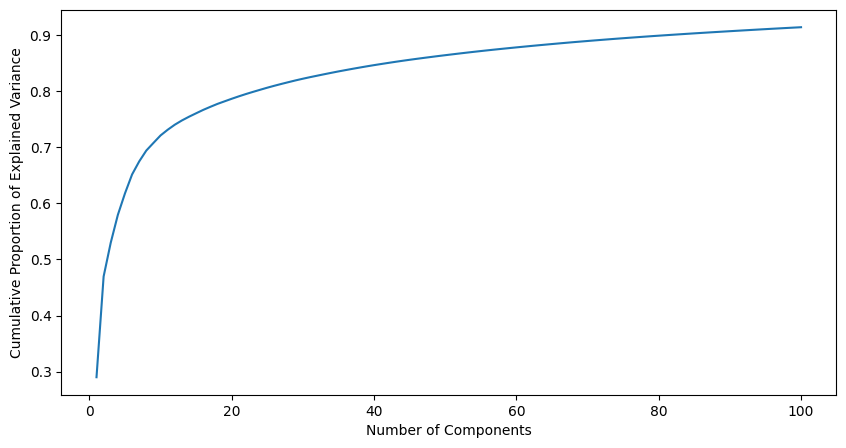

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

model_pca = PCA(n_components=100, svd_solver = 'full')
X_red_pca = model_pca.fit_transform(X_flat[:train_no])

var_explained = np.cumsum(model_pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.plot([i for i in range (1, 100 + 1)], var_explained)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.show()

In [ ]:
var_explained[:10]

array([0.29008754, 0.46957519, 0.52974366, 0.57933972, 0.61760152,
       0.65137323, 0.67454499, 0.69397266, 0.70749851, 0.72084751])

The first 3 components explain ~50% of total variability,  
the first 5 components explain ~60% of total variability and  
the first 9 components explain ~70% of total variability.

In the combination of PCA and K-Means clustering, the number of retained principal components can strongly influence clustering accuracy. Since 100 components already capture a large proportion of the total variance, testing higher numbers of components is not necessary. Moreover, the results of K-Means clustering are sensitive to the initial (random) cluster assignments. To account for this variability the maximum accuracy across five independent runs is reported when comparing different hyperparameter settings.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

def fit_PCA_Kmeans(X, train_no, y, PCA_n_clusters, random_states):
    """
    Perform PCA for dimensionality reduction followed by K-Means clustering,
    and evaluate clustering accuracy across multiple random initializations.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data matrix (flattened images).
    train_no : int
        Number of training samples to evaluate accuracy on.
    y : array-like, shape (n_samples,)
        True labels corresponding to X.
    PCA_n_clusters : int
        Number of principal components to retain in PCA.
    random_states : list of int
        Random seeds for K-Means initialization to ensure robustness.

    Returns
    -------
    accuracy : float
        Mean clustering accuracy across all random initializations.
    """

    # Store accuracy values for best run
    best_accuracy = 0

    # Step 1: Dimensionality reduction with PCA
    model_pca = PCA(n_components=PCA_n_clusters, svd_solver = 'full')
    X_train_pca = model_pca.fit_transform(X[:train_no])

    # Step 2: Run K-Means clustering for each random seed
    for random_state in random_states:
        model_kmeans = KMeans(
            n_clusters=10,      # Fashion-MNIST has 10 classes
            n_init=10,          # number of centroid initializations
            random_state=random_state
        )

        # Step 3: Predict cluster assignments for the training subset
        y_train_pred = model_kmeans.fit_predict(X_train_pca)

        # Step 4: Compute clustering accuracy using optimal label mapping and compare to previous best accuracy
        accuracy = calculate_accuracy(y[:train_no], y_train_pred)[0]
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_pca_model = model_pca
          best_kmeans_model = model_kmeans

    return best_accuracy, best_pca_model, best_kmeans_model

In [ ]:
random_states = [45, 678, 987, 1238, 567]
PCA_n_clusters = [3, 5, 10, 20, 30, 50, 70, 100]

dict_PCA_Kmeans = {}

for n in PCA_n_clusters:
  dict_PCA_Kmeans[n] = fit_PCA_Kmeans(
      X = X_flat,
      train_no = train_no,
      y = y,
      PCA_n_clusters = n,
      random_states = random_states)[0]
  print(f'Accuracy for PCA with {n} components and K-Means Clustering using reduced dataset: {dict_PCA_Kmeans[n]:.2f}')

Accuracy for PCA with 3 components and K-Means Clustering using reduced dataset: 0.47
Accuracy for PCA with 5 components and K-Means Clustering using reduced dataset: 0.51
Accuracy for PCA with 10 components and K-Means Clustering using reduced dataset: 0.47
Accuracy for PCA with 20 components and K-Means Clustering using reduced dataset: 0.48
Accuracy for PCA with 30 components and K-Means Clustering using reduced dataset: 0.54
Accuracy for PCA with 50 components and K-Means Clustering using reduced dataset: 0.54
Accuracy for PCA with 70 components and K-Means Clustering using reduced dataset: 0.48
Accuracy for PCA with 100 components and K-Means Clustering using reduced dataset: 0.47


In [ ]:
df_pca_kmeans =  pd.DataFrame.from_dict(dict_PCA_Kmeans, orient='index', columns=['Accuracy'])
df_pca_kmeans['n_components'] = df_pca_kmeans.index
df_pca_kmeans = df_pca_kmeans.reset_index(drop=True)
df_pca_kmeans.to_excel(os.path.join(working_dir, 'accuracy_train_pca_kmeans.xlsx'))

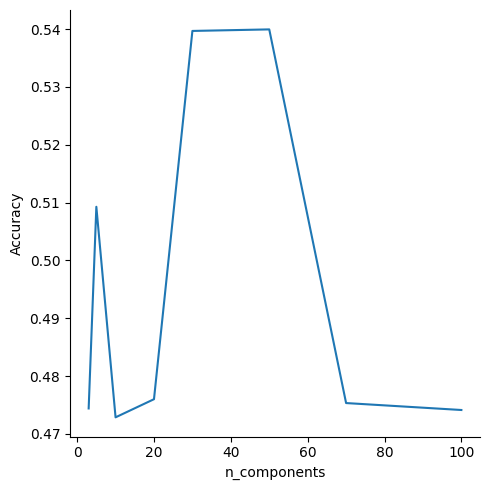

In [ ]:
sns.relplot(data=df_pca_kmeans, x='n_components', y='Accuracy', kind='line')
plt.show()

**Optimized Model Trained on Full Dataset (Training and Test) with Evaluation on Test Data**

In [ ]:
random_states = [45, 678, 987, 1238, 567]

accuracy, model_pca, model_kmeans = fit_PCA_Kmeans(
                X = X_flat,
                train_no = X_flat.shape[0],
                y = y,
                PCA_n_clusters = 40,
                random_states = random_states)

print(f'Accuracy of optimized model using full dataset: {accuracy:.2f}')

first_index_test = X_train.shape[0]
y_pred = model_kmeans.labels_
y_test_pred = y_pred[first_index_test:]

accuracy, mapping = calculate_accuracy(y_test, y_test_pred)

print(f'Accuracy of optimized model using test dataset: {accuracy:.2f}')

Accuracy of optimized model using full dataset: 0.55
Accuracy of optimized model using test dataset: 0.56


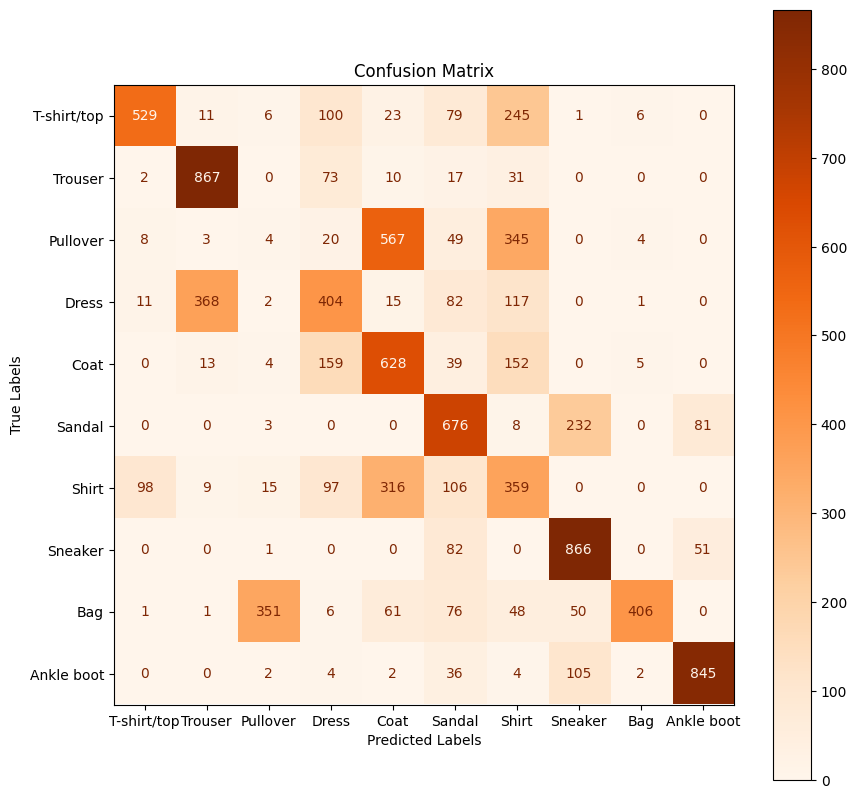

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, mapping)

**Summary**

- Hyperparameter range investigated: Principal component dimensions between 3 and 100 were tested.

- Best setting: Retaining 30-50 principal components before applying K-Means yielded the most stable clustering performance.

- In the absence of labeled data the appropriate number of principal components can be determined from the plot of cumulative explained variance as a function of the number of components.

- Accuracy on test dataset: The optimized PCA + K-Means pipeline achieved an accuracy of approximately 56%.

- Labels well clustered: Distinct category `Ankle Boot` was clustered with relatively high consistency.

- Labels not well clustered: Classes  `Pullover`, `Dress`, `Shirt` and `Bag` showed substantial overlap with other classes leading to frequent misclassifications.

### <span style = "color: red" > PCA followed by Hierarchical (Agglomerative) Clustering

Hierarchical (Agglomerative) Clustering is a bottom-up clustering method that begins by treating each of the n observations as its own cluster. At each step, the two clusters that are most similar according to a chosen dissimilarity measure such as Euclidean distance or cosine dissimilarity are merged. This process continues iteratively, reducing the number of clusters from n to n-1, then n-2, and so on, until all observations are combined into a single cluster. The sequence of merges can be visualized in a dendrogram which illustrates the hierarchical structure of the data.

Since dissimilarity is initially defined only between individual observations, it must be extended to groups of observations. This extension is achieved through the concept of linkage which specifies how the dissimilarity between two clusters is calculated. Common linkage criteria include single linkage (minimum distance), complete linkage (maximum distance), average linkage (mean distance), and Ward's method (minimizing the increase in within-cluster variance).

- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An introduction to statistical learning with Python. Springer.

As with K-Means Clustering variations in individual features may become indistinguishable because their contribution to the overall distance is often negligible. To mitigate this effect, PCA is applied to reduce the dimensionality of the feature space.

**Model Optimization with Hyperparameter Tuning**

In [ ]:
# https://scikit-learn.org/stable/modules/clustering.html

def fit_PCA_hier_clust(X, train_no, y, PCA_n_clusters, metric, linkage):
    """
    Perform PCA for dimensionality reduction followed by Hierarchical (Agglomerative) Clustering,
    and evaluate clustering accuracy on a subset of the data.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data matrix (flattened images).
    train_no : int
        Number of training samples to use for clustering and evaluation.
    y : array-like, shape (n_samples,)
        True labels corresponding to X.
    PCA_n_clusters : int
        Number of principal components to retain in PCA.
    metric : str
        Dissimilarity metric used for hierarchical clustering (e.g., 'euclidean', 'cosine').
    linkage : str
        Linkage criterion to define cluster dissimilarity (e.g., 'ward', 'average', 'complete').

    Returns
    -------
    accuracy : float
        Clustering accuracy after optimal label mapping.
    model_pca : PCA object
        Fitted PCA model.
    model_hier : AgglomerativeClustering object
        Fitted hierarchical clustering model.
    """

    # Step 1: Dimensionality reduction with PCA
    model_pca = PCA(n_components=PCA_n_clusters, svd_solver='full')
    X_train_pca = model_pca.fit_transform(X[:train_no])

    # Step 2: Hierarchical clustering
    model_hier = AgglomerativeClustering(
        n_clusters=10,
        metric=metric,
        linkage=linkage
    )
    y_train_pred = model_hier.fit_predict(X_train_pca)

    # Step 3: Evaluate clustering accuracy using optimal label mapping
    accuracy = calculate_accuracy(y[:train_no], y_train_pred)[0]

    return accuracy, model_pca, model_hier


In [ ]:
PCA_n_clusters = [3, 5, 10, 20, 30, 50, 70, 100]
metrics = ['euclidean', 'cosine']
linkages = ['ward', 'average', 'complete']

dict_PCA_hier_clust = {}

for n in PCA_n_clusters:
  for metric in metrics:
    for linkage in linkages:
      if linkage == 'ward' and metric != 'euclidean':
          continue

      dict_PCA_hier_clust[(n, metric, linkage)] = fit_PCA_hier_clust(
          X = X_flat,
          train_no = train_no,
          y = y,
          PCA_n_clusters = n,
          metric = metric,
          linkage = linkage)[0]

      print(f'Accuracy for PCA with {n} components, {metric} metric and {linkage} linkage: {dict_PCA_hier_clust[(n, metric, linkage)]: .2f}')

Accuracy for PCA with 3 components, euclidean metric and ward linkage:  0.51
Accuracy for PCA with 3 components, euclidean metric and average linkage:  0.42
Accuracy for PCA with 3 components, euclidean metric and complete linkage:  0.38
Accuracy for PCA with 3 components, cosine metric and average linkage:  0.46
Accuracy for PCA with 3 components, cosine metric and complete linkage:  0.39
Accuracy for PCA with 5 components, euclidean metric and ward linkage:  0.53
Accuracy for PCA with 5 components, euclidean metric and average linkage:  0.45
Accuracy for PCA with 5 components, euclidean metric and complete linkage:  0.47
Accuracy for PCA with 5 components, cosine metric and average linkage:  0.46
Accuracy for PCA with 5 components, cosine metric and complete linkage:  0.44
Accuracy for PCA with 10 components, euclidean metric and ward linkage:  0.45
Accuracy for PCA with 10 components, euclidean metric and average linkage:  0.45
Accuracy for PCA with 10 components, euclidean metric a

In [ ]:
df_pca_hier_clust =  pd.DataFrame.from_dict(dict_PCA_hier_clust, orient='index', columns=['Accuracy'])
df_pca_hier_clust['n_components'] = df_pca_hier_clust.index.map(lambda x: x[0])
df_pca_hier_clust['metric'] = df_pca_hier_clust.index.map(lambda x: x[1])
df_pca_hier_clust['linkage'] = df_pca_hier_clust.index.map(lambda x: x[2])
df_pca_hier_clust = df_pca_hier_clust.reset_index(drop=True)
df_pca_hier_clust.to_excel(os.path.join(working_dir, 'accuracy_train_pca_hier.xlsx'))
df_pca_hier_clust.sort_values(by=['Accuracy'], ascending=False).head()

,Accuracy,n_components,metric,linkage
25,0.615333,50,euclidean,ward
20,0.575600,30,euclidean,ward
5,0.526000,5,euclidean,ward
0,0.510000,3,euclidean,ward
19,0.503133,20,cosine,complete


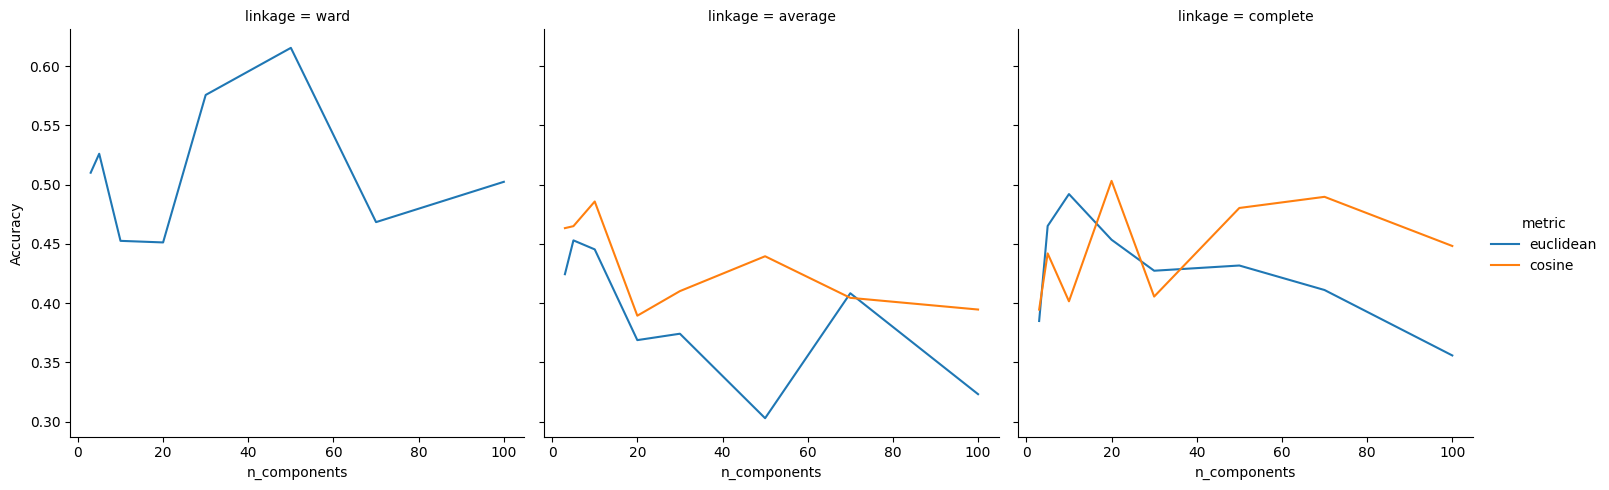

In [ ]:
sns.relplot(data=df_pca_hier_clust, x='n_components', y='Accuracy', hue='metric', col='linkage', kind='line')
plt.show()

**Optimized Model Trained on Full Dataset (Training and Test) with Evaluation on Test Data**

In [ ]:
data_indices = [i for i in range(train_no)] + [i for i in range(X_train.shape[0], X_flat.shape[0])]
first_index_test = train_no
accuracy, model_pca, model_hier = fit_PCA_hier_clust(
    X = X_flat[data_indices],
    train_no = len(data_indices), #fit on half tr
    y = y[data_indices],
    PCA_n_clusters = 50,
    metric = 'euclidean',
    linkage = 'ward'
)

print(f'Accuracy of optimized model using full dataset: {accuracy:.2f}')

y_pred = model_hier.labels_
y_test_pred = y_pred[first_index_test:]
accuracy, mapping = calculate_accuracy(y_test, y_test_pred)

print(f'Accuracy of optimized model using test dataset: {accuracy:.2f}')

Accuracy of optimized model using full dataset: 0.52
Accuracy of optimized model using test dataset: 0.53


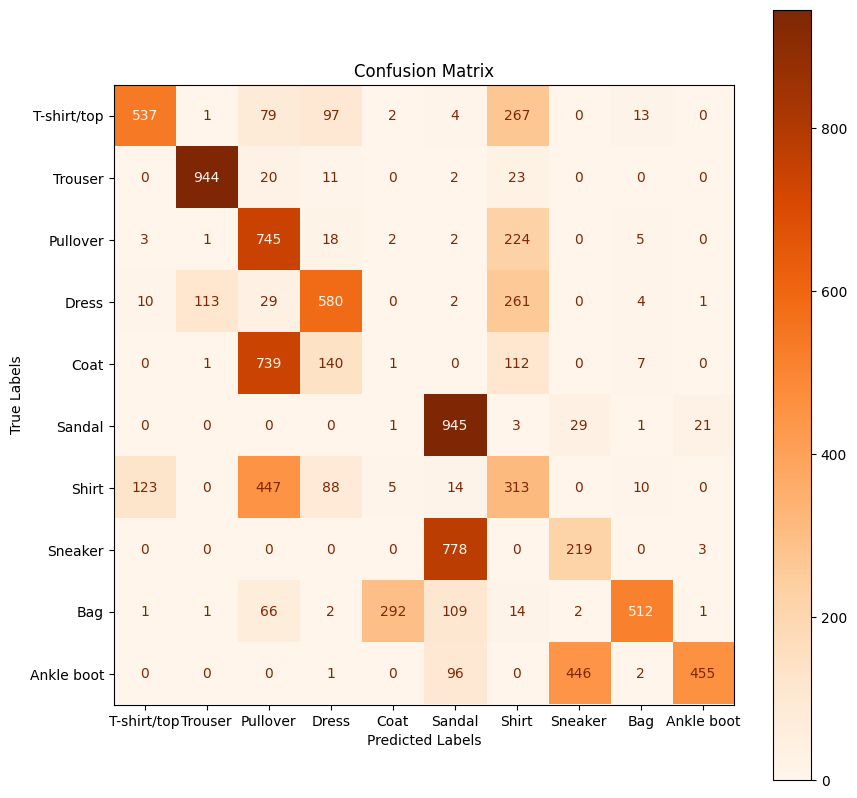

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, mapping)

**Summary**

- Hyperparameter range investigated:  
Principal component dimensions between 3 and 100 were tested.
Distances metrics were Euclidean and Cosine.  
Ward, average and complete linkage was investigated.

- Best setting: Retaining around 50 principal components before applying Hierarchical (Agglomerative) Clustering with Ward linkage and Euclidean distance yielded the most stable clustering performance.

- In the absence of labeled data the number of principal components can be selected by inspecting the cumulative explained variance curve as a function of the component count. Cosine similarity seems to be a more suitable choice of distance metric, since even after PCA high-dimensional feature spaces may obscure differences in certain components when relying solely on Euclidean distance.

- Accuracy on test dataset: The optimized PCA + Hierarchical Clustering pipeline achieved an accuracy of approximately 53%, but only 25% of training data and all test data were used for clustering. Using a larger number of observations exceeded the available RAM capacity and caused the process to fail.

- Labels well clustered: Distinct category such as `Trousers` was clustered with relatively high consistency.

- Labels not well clustered: Classes such as `Pullover`, `Coat` and `Shirt` showed substantial overlap with one another, while `Dress` and `Bag` were also frequently misclassified.

### <span style = "color: red" > Non-negative Matrix Factorization (NMF) for clustering by detecting latent data structures
Using Non-Negative Matrix Factorization (NMF) the "image-pixel"-matrix (15,000 x 784) is decomposed into a "image-category" matrix (15,000 x 10) and a "category-pixel" matrix (10 x 784) with the number of components (categories) fixed at 10. The categories represent latent structures in the "image-pixel"-matrix.

- https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

In [ ]:
model_nmf = NMF(n_components=10, init='random', random_state=42, max_iter=2000, solver='cd')
X_train_nmf = model_nmf.fit_transform(X_flat[:train_no])
X_train_nmf.shape, model_nmf.components_.shape

((15000, 10), (10, 784))

**Model Optimization with Hyperparameter Tuning**

In NMF the regularization parameter $\alpha$ can be fine-tuned to control model complexity and thereby reduce the risk of overfitting.

  - `alpha_W`: A constant that multiplies the regularization terms of matrix W. Setting it to zero (default) applies no regularization to W, applies same value to H.

 $ $

$
L(W, H) = 0.5 \cdot \|X - WH\|^2_{\text{loss}}
+ \\0.5 \cdot \alpha_W  \cdot n_{\text{features}} \cdot \|W\|^2_{\text{Fro}}
+ 0.5 \cdot \alpha_H  \cdot n_{\text{samples}} \cdot \|H\|^2_{\text{Fro}}
$
$ $

| Symbol | Meaning |
|--------|---------|
| \(X\) | Input data matrix of shape \((n_samples, n_features) |
| \(W\) | Basis matrix (non-negative), shape \(n_samples, r) |
| \(H\) | Coefficient matrix (non-negative), shape \(r, n_features) |
| n_samples | Number of features (columns of \(X\)) |
| n_features | Number of samples (rows of \(X\)) |
| alpha_W | Regularization strength for \(W\) (controls L2 penalty magnitude) |
| alpha_H| Regularization strength for \(H\) |


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

def fit_nmf(X, train_no, y, alpha):
    """
    Perform Non-negative Matrix Factorization (NMF) for dimensionality reduction
    and clustering, and evaluate clustering accuracy on a subset of the data.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data matrix (flattened images).
    train_no : int
        Number of training samples to use for clustering and evaluation.
    y : array-like, shape (n_samples,)
        True labels corresponding to X.
    alpha : float
        Constant that multiplies the regularization terms. Set to zero to no regularization.

    Returns
    -------
    accuracy : float
        Clustering accuracy after optimal label mapping.
    model_nmf : NMF object
        Fitted NMF model.
    y_pred : array-like
        Predicted cluster labels (integer assignments).
    """

    # Step 1: Non-negative Matrix Factorization
    model_nmf = NMF(n_components=10, init='random', random_state=42, max_iter=2000, alpha_W=alpha, solver='cd') # Specify solver for older versions

    # Fit NMF and transform the data
    X_train_nmf = model_nmf.fit_transform(X[:train_no])

    # Step 2: Assign cluster labels based on the component with the highest value
    y_train_pred = np.argmax(X_train_nmf, axis=1)

    # Step 3: Evaluate clustering accuracy using optimal label mapping
    accuracy = calculate_accuracy(y[:train_no], y_train_pred)[0] # calculate_accuracy now returns accuracy

    return accuracy, model_nmf

In [ ]:
alphas = [0, 0.001, 0.01, 0.1, 1, 2, 5, 10]

dict_nmf = {}

for alpha in alphas:
  accuracy, model_nmf = fit_nmf(
      X = X_flat,
      train_no = train_no,
      y = y,
      alpha = alpha)

  dict_nmf[alpha] = accuracy

  print(f'Accuracy for NMF with alpha {alpha}: {dict_nmf[alpha]:.2f}')

Accuracy for NMF with alpha 0: 0.48
Accuracy for NMF with alpha 0.001: 0.48
Accuracy for NMF with alpha 0.01: 0.55
Accuracy for NMF with alpha 0.1: 0.55
Accuracy for NMF with alpha 1: 0.56
Accuracy for NMF with alpha 2: 0.56
Accuracy for NMF with alpha 5: 0.54
Accuracy for NMF with alpha 10: 0.46


In [ ]:
df_nmf =  pd.DataFrame.from_dict(dict_nmf, orient='index', columns=['Accuracy'])
df_nmf['alpha'] = df_nmf.index
df_nmf = df_nmf.reset_index(drop=True)
df_nmf.to_excel(os.path.join(working_dir, 'accuracy_train_nmf.xlsx'))
df_nmf.sort_values(by=['Accuracy'], ascending=False).head()

,Accuracy,alpha
4,0.564600,1.00
5,0.562533,2.00
3,0.550733,0.10
2,0.545133,0.01
6,0.544400,5.00


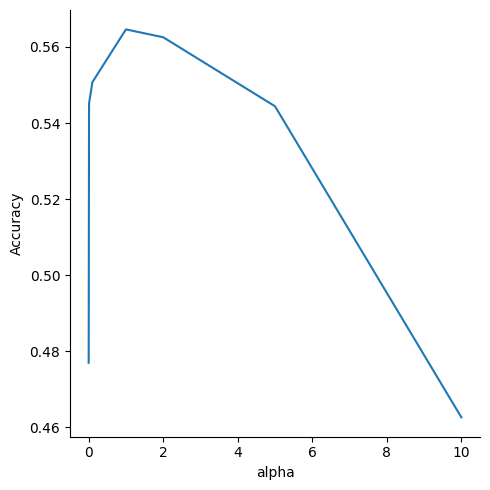

In [ ]:
sns.relplot(data=df_nmf, x='alpha', y='Accuracy', kind='line')
plt.show()

**Optimized Model Trained on Full Dataset (Training and Test) with Evaluation on Test Data**

In [ ]:
accuracy, model_nmf = fit_nmf(
    X = X_flat,
    train_no = X_flat.shape[0],
    y = y,
    alpha = 1)

print(f'Accuracy of optimized model using full dataset: {accuracy:.2f}')

first_index_test = X_train.shape[0]
y_pred = model_nmf.transform(X_flat).argmax(axis=1)
y_test_pred = y_pred[first_index_test:]
accuracy, mapping = calculate_accuracy(y_test, y_test_pred)

print(f'Accuracy of optimized model using test dataset: {accuracy:.2f}')

Accuracy of optimized model using full dataset: 0.56
Accuracy of optimized model using test dataset: 0.56


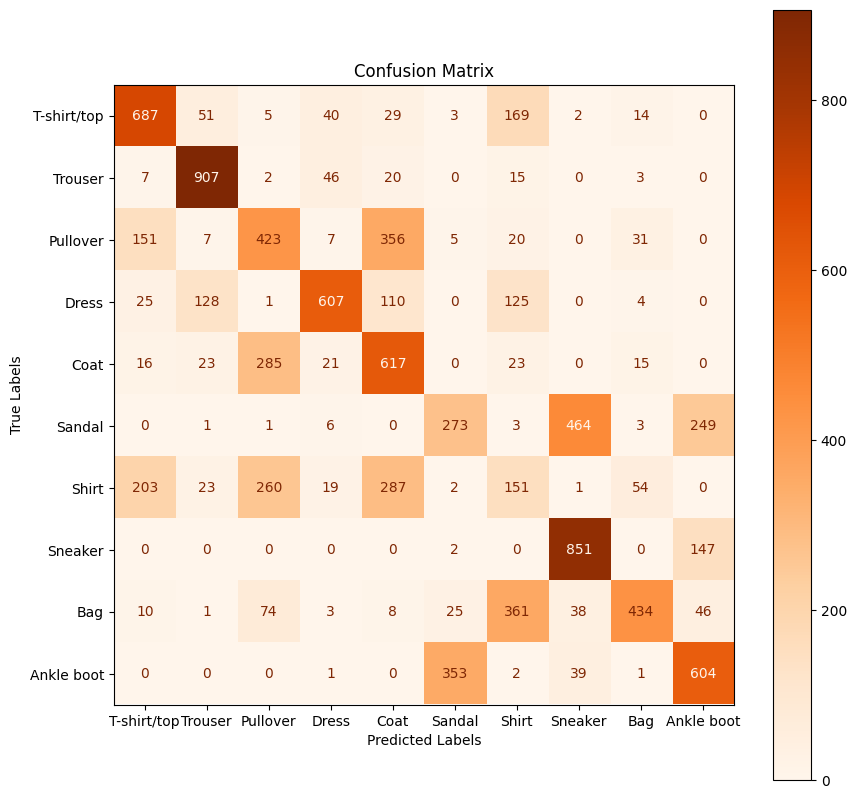

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, mapping)

**Summary**

- Hyperparameter range investigated: Regularization strengths $\alpha$ between 0 and 10 were tested

- Best setting: The most stable clustering performance was achieved with $\alpha = 1$ balancing reconstruction accuracy and generalization

- Finding $\alpha$ without labelled data is difficult.

- Accuracy on test dataset: The optimized NMF clustering pipeline achieved an accuracy of approximately 56% on the test dataset

- Labels well clustered: Distinct category as `Trousers` was consistently well separated.

- Labels not well clustered: Classes such as `Sandal`and `Shirt` showed substantial overlap with one other categories, while `Pullover` and `Bag` were also frequently misclassified.

## <span style = "color: red" > Supervised Learning

For comparison Logistic Regression is employed as a supervised machine learning baseline. Given the high dimensionality of the feature space, an L1 penalty on the regression coefficients is introduced to prevent overfitting. This regularization approach is analogous to Lasso regression which applies an absolute value penalty in the context of linear models with continuous, normally distributed target variables.

**Model Optimization and Hyperparameter Tuning**


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def fit_logistic_regression(X, y, train_no, C):
    """
    Train and evaluate a Logistic Regression classifier with L1 regularization.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data matrix (e.g., flattened images).
    y : array-like, shape (n_samples,)
        Ground-truth labels corresponding to X.
    train_no : int
        Number of samples from the dataset to use for training/validation.
    C : float
        Inverse of regularization strength; smaller values specify stronger regularization.

    Returns
    -------
    accuracy_train : float
        Classification accuracy on the training subset.
    accuracy_val : float
        Classification accuracy on the validation subset.
    model_logistic : LogisticRegression object
        Trained logistic regression model.
    """

    # Split the first `train_no` samples into training and validation sets
    X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(
        X_flat[:train_no],
        y[:train_no],
        test_size=0.2,
        random_state=42
    )

    # Initialize logistic regression with L1 penalty and specified regularization strength
    model_logistic = LogisticRegression(
        max_iter=1000,
        penalty='l1',
        C=C,
        solver='liblinear'
    )

    model_logistic.fit(X_train_red, y_train_red)


    # Compute accuracy on training and validation sets
    accuracy_train = model_logistic.score(X_train_red, y_train_red)
    accuracy_val = model_logistic.score(X_val_red, y_val_red)

    return accuracy_train, accuracy_val, model_logistic

In [ ]:
C = [0.0001, 0.001, 0.01, 0.1, 1]

dict_logistic_train = {}
dict_logistic_val = {}

for c in C:
  accuracy_train, accuracy_val, model_logistic = fit_logistic_regression(
      X = X_flat,
      y = y,
      train_no = train_no,
      C = c)

  dict_logistic_train[c] = accuracy_train
  dict_logistic_val[c] = accuracy_val

  print(f'Accuracy for C {c} on training data: {dict_logistic_train[c]:.2f}')
  print(f'Accuracy for C {c} on validation data: {dict_logistic_val[c]:.2f}')


Accuracy for C 0.0001 on training data: 0.78
Accuracy for C 0.0001 on validation data: 0.77
Accuracy for C 0.001 on training data: 0.86
Accuracy for C 0.001 on validation data: 0.84
Accuracy for C 0.01 on training data: 0.91
Accuracy for C 0.01 on validation data: 0.83
Accuracy for C 0.1 on training data: 0.93
Accuracy for C 0.1 on validation data: 0.80
Accuracy for C 1 on training data: 0.94
Accuracy for C 1 on validation data: 0.79


In [ ]:
df_logistic =  pd.DataFrame.from_dict(dict_logistic_train, orient='index', columns=['Accuracy train'])
df_logistic['C'] = df_logistic.index
df_logistic = df_logistic.reset_index(drop=True)
df_logistic['Accuracy val'] = df_logistic['C'].map(dict_logistic_val)
df_logistic.to_excel(os.path.join(working_dir, 'accuracy_logistic.xlsx'))

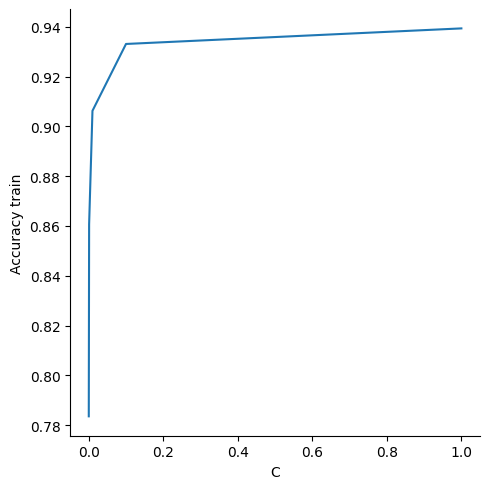

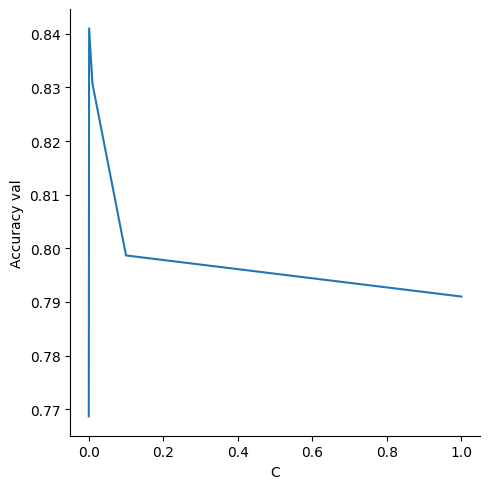

In [ ]:
sns.relplot(data=df_logistic, x='C', y='Accuracy train', kind='line')
sns.relplot(data=df_logistic, x='C', y='Accuracy val', kind='line')
plt.show()

**Optimized Model Trained on Full Training Dataset with Evaluation on Test Data**

In [ ]:
model_logistic = LogisticRegression(
        max_iter=1000,
        penalty='l1',
        C=0.001,
        solver='liblinear'
    )
X_train_flat = X_train.reshape(-1, pix_dim**2)
X_test_flat = X_test.reshape(-1, pix_dim**2)

y_train_pred = model_logistic.fit(X_train_flat, y_train)
y_test_pred = model_logistic.predict(X_test_flat)

# Compute accuracy on training and validation sets
accuracy_train = model_logistic.score(X_train_flat, y_train)
accuracy_test = model_logistic.score(X_test_flat, y_test)

print(f'Training accuracy of optimized model trained on full training dataset: {accuracy_train:.2f}')
print(f'Test accuracy of optimized model trained on full training dataset: {accuracy_test:.2f}')


Training accuracy of optimized model trained on full training dataset: 0.86
Test accuracy of optimized model trained on full training dataset: 0.84


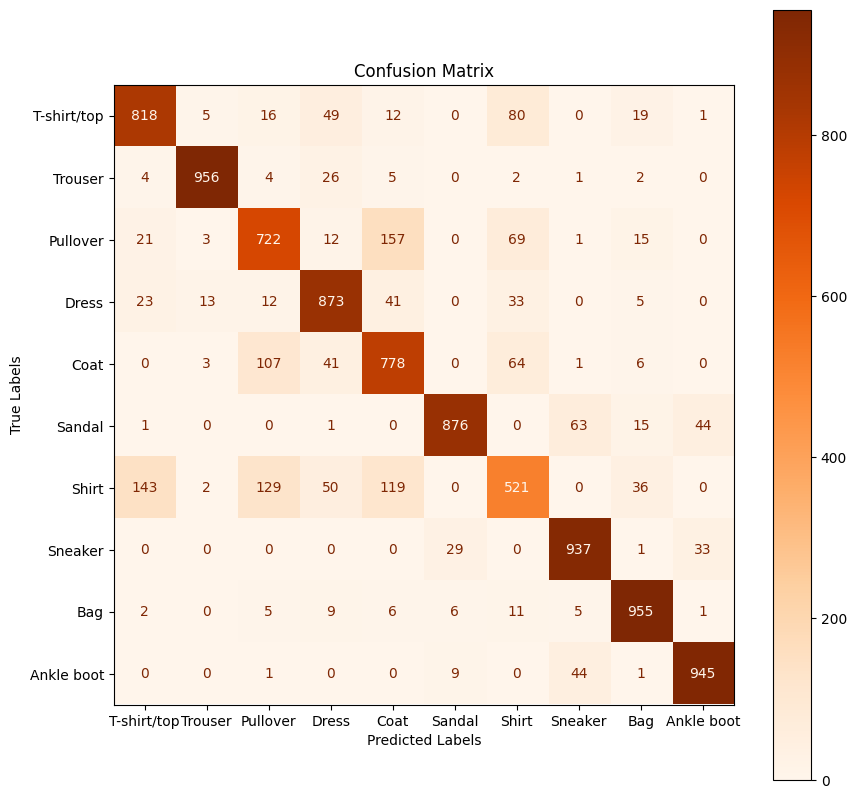

In [ ]:
# Compute confusion matrix between true and remapped predictions
cm = confusion_matrix(y_test, y_test_pred)

# Create figure and axis for display
fig, ax = plt.subplots(figsize=(10, 10))  # adjust figure size if needed

# Initialize ConfusionMatrixDisplay with computed matrix and class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_real)

# Plot the confusion matrix with chosen colormap
disp.plot(ax=ax, cmap='Oranges')

# Add title and axis labels
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")

# Show the plot
plt.show()

**Summary**

- Hyperparameter range investigated: Regularization strengths $C$ (inverse of penalty) between 0.0001 and 1 were tested.  

- Best setting: The most stable classification performance was achieved with $C = 0.001$ providing the best balance between regularization and accuracy.  

- Accuracy on test dataset: The optimized Logistic Regression model with L1 regularization achieved a test accuracy of 84%. In the optimized model an overfitting is avoided as seen on the training data accuracy of 86%

- Labels well classified: Distinct categories such as `Trousers`, `Sneaker`, `Bag` and `Ankle Boot` were consistently predicted with high accuracy.  

- Labels not well classified: Classes such as `Shirt`, `Pullover`, and `Coat` showed substantial overlap with one another


## <span style = "color: red" > Comparison of All Techniques

The following table presents a comparison of hyperparameter tuning results and the corresponding model accuracies on the test dataset. For the unsupervised methods, clustering accuracy was computed using the full dataset whereas for the supervised Logistic Regression model, the full training dataset was employed. In the case of PCA followed by Hierarchical Clustering memory limitations were encountered and therefore only a reduced dataset could be used for clustering.


| Methodology                 | Parameter             | Investigated Range                | Optimum                | Impact        | Test Accuracy (Optimized) |
|--------------------------|-----------------------|-----------------------------------|------------------------|---------------|----------------------------|
| **PCA + K-Means**        | # Principal Components | 3 - 100                           | 30-50                  | High          | 56%                       |
| **PCA + Hierarchical**   | # Principal Components | 3 - 100                           | ~50                    | High          | 53% (RAM-limited - smaller dataset)         |
| **PCA + Hierarchical**   | Linkage Method        | Ward, Average, Complete           | Ward                   | High          | —                          |
| **PCA + Hierarchical**   | Distance Metric       | Euclidean, Cosine                 | Euclidean              | Moderate      | —                          |
| **NMF**   | Regularization α      | 0 - 10  | 1-2                    | High     | 56%  |
| **Supervised: Logistic Regression**  | C (Reg. Strength)     | 0.0001 - 1            | 0.001                  | High          | 84%                    |

The supervised Logistic Regression model clearly outperformed all unsupervised clustering techniques achieving substantially higher accuracy on the test dataset. All unsupervised techniques give similar test accuracy.

Logistic Regression is trained with ground-truth labels directly learning the mapping between input features and categories.

Clustering methods (PCA+KMeans, PCA+Hierarchical, NMF) operate without labels. So they can only group data based on similarity in feature space which may not align with the true categories.

The fashion items are provided as grayscale images. Crucial attributes such as size, texture and material which play an important role in distinguishing fashion items in real-world contexts are not captured and therefore cannot be utilized for clustering.

## <span style = "color: red" > Summary and Conclusion

**Description and Exploratory Data Analysis**

The Fashion-MNIST dataset contains 70,000 grayscale images (28x28 pixels) evenly distributed across 10 fashion categories. The data is clean with no missing values, duplicates or outliers and pixel intensities span the full 0-255 range, so no additional normalization is required.

Exploratory analysis showed clear intra-class variability, for example in `Sandal` and `Bag` and strong inter-class similarity between categories such as `Pullover`, `Coat` and `Shirt` which often share overlapping silhouettes. Average images and correlation analysis confirmed these similarities. Pixel intensity distributions revealed that items like `Sneaker`, `Sandal` and `Trousers` appear darker due to covering less of the frame.

Overall, the dataset is well-structured but challenging, making it a realistic benchmark for clustering and classification tasks.

**Unsupervised and Supervised Modelling**

This study evaluated both unsupervised clustering techniques (PCA + K-Means, PCA + Hierarchical Clustering, and Non-negative Matrix Factorization) and a supervised baseline (Logistic Regression) on the Fashion-MNIST dataset. All models were optimized tuning hyperparameter.

Unsupervised methods:

- PCA + K-Means achieved a test accuracy of 56% when retaining 40 principal components.

- PCA + Hierarchical Clustering reached 53% accuracy with 50 components, Ward linkage and Euclidean distance though memory limitations restricted the number of observations.

- NMF with regularization parameter $\alpha = 1$ also achieved 56% accuracy, balancing reconstruction quality and generalization.

Across all clustering methods categories such as `Trousers` and `Ankle Boot` were consistently well separated, while visually similar classes like `Pullover`, `Coat` and `Shirt` showed substantial overlap and frequent misclassification.

Supervised method:

- Logistic Regression with L1 regularization (best setting $C = 0.001
) achieved 84% test accuracy.

Distinct categories such as `Trousers`, `Sneaker`, `Bag` and `Ankle boot` were classified with high reliability, while overlapping categories like `Shirt`, `Pullover` and `Coat` remained challenging.

**Conclusion**

The results demonstrate that supervised Logistic Regression substantially outperforms unsupervised clustering approaches, highlighting the advantage of leveraging labeled data to learn discriminative decision boundaries. In contrast, clustering methods are limited by their reliance on similarity in pixel space which does not fully capture semantic differences between fashion items. Moreover, the dataset's restriction to grayscale images omits real-world attributes such as size, texture and material which are crucial for distinguishing items in practice.

Overall, while unsupervised methods provide useful insights into latent structure and can achieve moderate alignment with true categories, supervised learning remains the more effective strategy for accurate classification on Fashion-MNIST. It is highly likely that accuracy could be further improved by employing a Convolutional Neural Network (CNN) which explicitly captures the two-dimensional spatial structure of the images during modeling.

Unsupervised learning methods are powerful in scenarios lacking labeled data and can be leveraged during preprocessing to uncover latent structures or reduce dimensionality.

## <span style = "color: red" > Literature

- TensorFlow. (n.d.). Fashion-MNIST. In TensorFlow Datasets Catalog. Retrieved October 5, 2025, from https://www.tensorflow.org/datasets/catalog/fashion_mnist

- Wikipedia contributors. (n.d.). Fashion-MNIST. In Wikipedia. Retrieved October 5, 2025, from https://en.wikipedia.org/wiki/Fashion_MNIST

- EITCA Academy. (n.d.). What is the difference between the Fashion-MNIST dataset and the classic MNIST dataset? Retrieved October 5, 2025, from https://eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/further-steps-in-machine-learning/machine-learning-use-case-in-fashion/examination-review-machine-learning-use-case-in-fashion/what-is-the-difference-between-the-fashion-mnist-dataset-and-the-classic-mnist-dataset/

- SciPy. (2016). scipy.optimize.linear_sum_assignment. In SciPy v0.18.1 Reference Guide. Retrieved October 5, 2025, from https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html

- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An introduction to statistical learning with Python. Springer.

- DataJobs. (n.d.). Recommender Systems [Netflix]. Retrieved October 5, 2025, from https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- Scikit-learn. (n.d.). PCA: Principal component analysis. In scikit-learn: Machine learning in Python. Retrieved October 5, 2025, from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

- Scikit-learn. (n.d.). KMeans clustering. In scikit-learn: Machine learning in Python. Retrieved October 5, 2025, from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

- Scikit-learn. (n.d.). Clustering. In scikit-learn: Machine learning in Python. Retrieved October 5, 2025, from https://scikit-learn.org/stable/modules/clustering.html


## <span style = "color: red" > Support

- Microsoft. (2025). Copilot (GPT-5) [Large language model]. https://copilot.microsoft.com/ : Microsoft Copilot was used to support the BBC News classification project by assisting with Markdown table compilation, Markdown equation writing and text-rephrasing and the compilation of the summary.

- Notebook was created in Google Colab with AI-assisted coding support.

